In [1]:
import torchvision.transforms.functional as TF

from models import  caption
from datasets import coco
from configuration import Config
from engine import evaluate

from PIL import Image
import numpy as np
import random
import os
import json

import torch
from configuration import Config
from transformers import BertTokenizer

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from models import caption
from datasets import coco, utils



In [2]:
location = '..\\Bangla Dataset'

In [3]:
with open(os.path.join(location,'captions.json'),'r',encoding="utf8") as file:
    captions = json.load(file)

## Some images were captioned incorrectly

Caption of Image 2.png: ['অনেক মেয়ে মানুষ বসে আছে।', 'একটি নীল জামা পরা মহিলা একটি নীল ল্যাপটপ এর দিকে তাকিয়ে আছে এবং পিছনে  তার দিকে বসে শারি পরে তাকিয়ে আছে অনেকগুলো মহিলা। ']


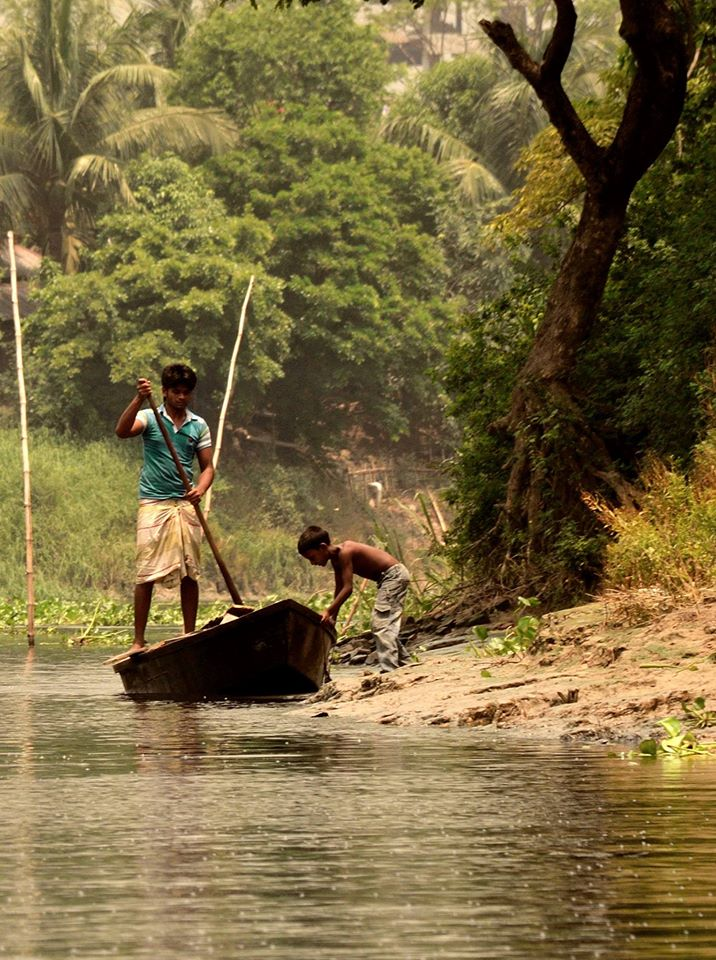

Caption of Image 3.png: ['অনেক মানুষ একসাথে বসে কাজ করছে।', '২ টি  ছোট ছেলে একজন শার্ট প্যান্ট  দাড়িয়ে চেয়ে আছে আরেকজন বসে গার্মেন্টস এ কাজ করছে নীল  শার্ট পরে তাদের পিছনে অনেকগুলো মহিলা বসে দাড়িয়ে কাজ করছে।  ']


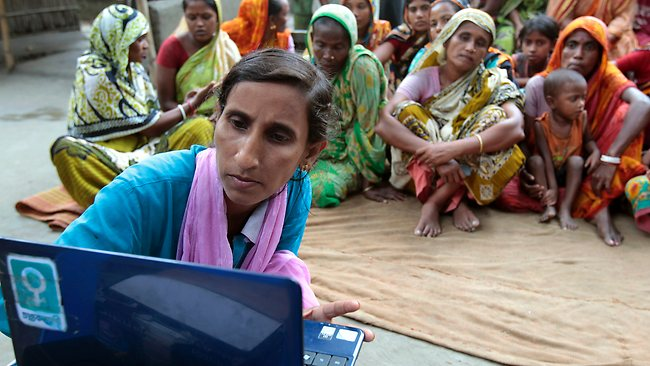

Caption of Image 4.png: ['ছয় জন মানুষ দাড়িয়ে আছে।', '৬ জন মানুষ এলোমেলো দাড়িয়ে আছে, তাদের মাঝে ২ জন ছেলে ৪ জন পুরুষ,  তাদের একজন লুঙ্গী পরে দাড়িয়ে আছে। ']


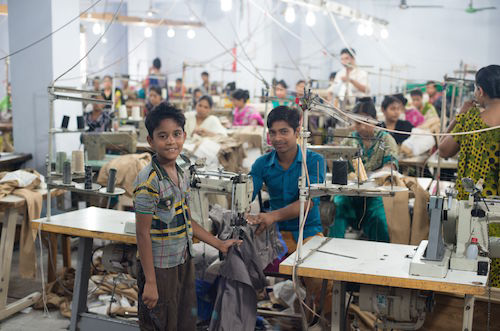

Caption of Image 56.png: ['কাপড় দিয়ে মাথা ঢেকে একজন বয়স্ক পুরুষ মানুষ তাকিয়ে আছে।', 'একটি বুড়ো পুরুষ একটি ঘাড় হলুদ চাদর পরে তাকিয়ে আছে যার দারিগুফ বড়। ']


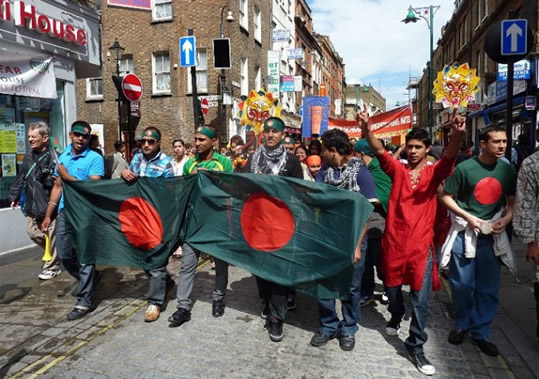

Caption of Image 57.png: ['কয়েকজন মানুষ রাস্তা দিয়ে হেঁটে যাচ্ছে।', 'কিছু ছেলে পুরুষ ২ টি বাংলাদেশী পতাকা হাতে রাস্তা ভরে মিছিল করছে। ']


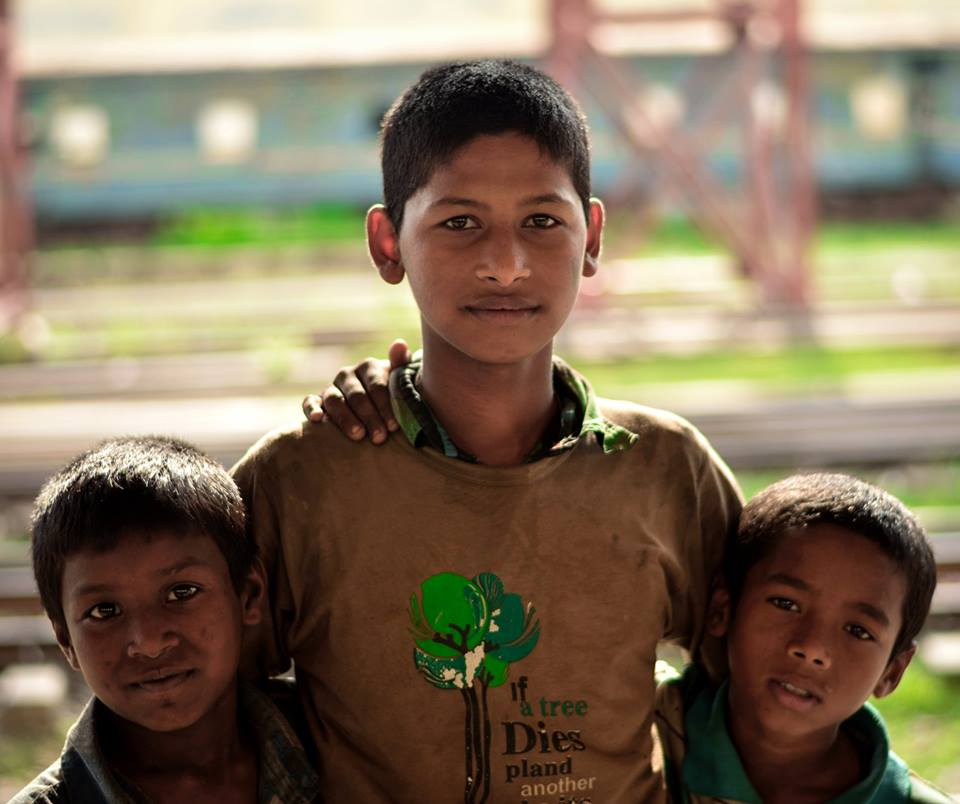

Caption of Image 58.png: ['তিনজন মানুষ আছে। একজন বালক ও দুইজন শিশু।', '৩ জন ছোট ছেলে মাঝের জন পাশের ২ জনকে ধরে দাড়িয়ে আছে তাদের পরনেশিরত গেঞ্জি। ']


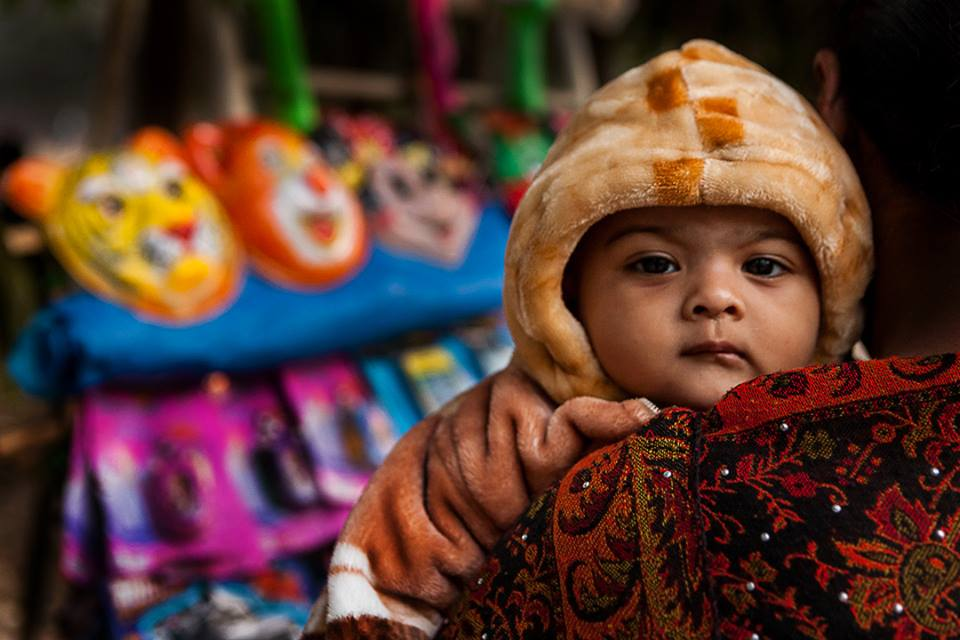

In [5]:
faulty_image_list = [1,2,3,55,56,57]
for i in faulty_image_list:
    print("Caption of Image {}: {}".format(captions[i]['filename'],captions[i]['caption']))
    image_path = os.path.join(location,'images',captions[i]['filename'])
    display(Image.open(image_path))

### A custom annotator program was created and the first 1000 images were correctly annotated in the file 'new_annotations.json'. But such low number of images is not ideal for training. As the faults were only noticed at the beginning of the dataset, the first 500 images were not considered for training or validation.

In [4]:
with open(os.path.join(location,'new_annotations.json'),'r',encoding="utf8") as file:
     new_captions = json.load(file)

In [6]:
with open(os.path.join(location,'captions.json'),'r',encoding="utf8") as file:
     captions = json.load(file)
captions = captions[:500]

In [8]:
np.random.shuffle(captions)

train_num = 7000 #int(0.8 * len(new_captions))
val_num = len(captions) - train_num
train_annotations = captions[:train_num ]
val_annotations = captions[train_num :train_num+val_num]

In [9]:
if not os.path.exists(os.path.join(location,'training')):
    os.mkdir(os.path.join(location,'training'))
if not os.path.exists(os.path.join(location,'validation')):
    os.mkdir(os.path.join(location,'validation'))
if not os.path.exists(os.path.join(location,'annotations')):
    os.mkdir(os.path.join(location,'annotations'))

In [ ]:
import shutil

for annotation in train_annotations:
    shutil.copy2(os.path.join(location,'images',annotation['filename']),os.path.join(location,'training'))

filename = os.path.join(location,'annotations','train_annotations.json')
with open(filename,'w',encoding='utf8') as file:
    json.dump(train_annotations,file,ensure_ascii=False)

for annotation in val_annotations:
    shutil.copy2(os.path.join(location,'images',annotation['filename']),os.path.join(location,'validation'))

filename = os.path.join(location,'annotations','val_annotations.json')
with open(filename,'w',encoding='utf8') as file:
    json.dump(val_annotations,file,ensure_ascii=False)

## Test the model 

In [ ]:
checkpoint_location = '../checkpoint.pth'

In [3]:
model, criterion = caption.build_model(Config())
model.load_state_dict(torch.load(checkpoint_location)['model'])

<All keys matched successfully>

In [28]:
image_path = '../Bangla Dataset/images/54.png'

In [20]:
image_path = 'G:\Pioneer Alpha\Task 3\Capture.PNG'

কযেকজন মানষ আছে ।


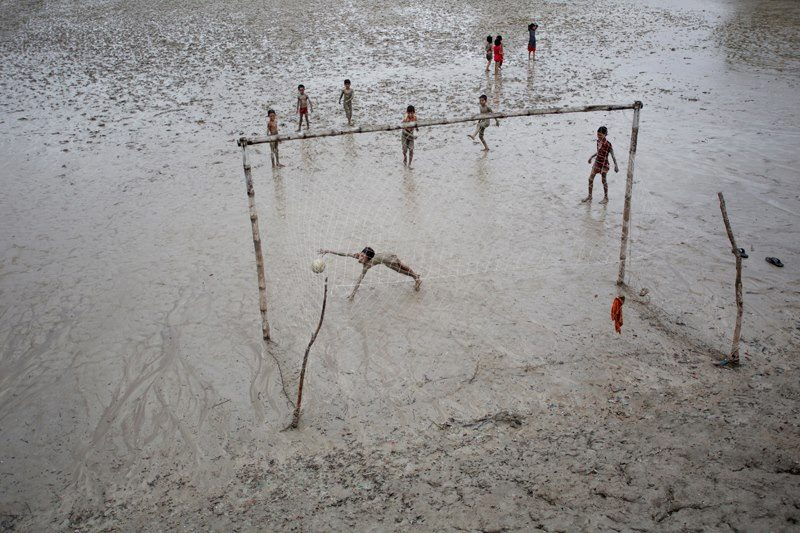

In [29]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

start_token = tokenizer.convert_tokens_to_ids(tokenizer._cls_token)
end_token = tokenizer.convert_tokens_to_ids(tokenizer._sep_token)

img = Image.open(image_path)
image = coco.val_transform(img)
image = image.unsqueeze(0)

def create_caption_and_mask(start_token, max_length):
    caption_template = torch.zeros((1, max_length), dtype=torch.long)
    mask_template = torch.ones((1, max_length), dtype=torch.bool)

    caption_template[:, 0] = start_token
    mask_template[:, 0] = False

    return caption_template, mask_template


caption, cap_mask = create_caption_and_mask(
    start_token, Config().max_position_embeddings)

@torch.no_grad()
def evaluate():
    model.eval()
    for i in range(Config().max_position_embeddings - 1):
        predictions = model(image, caption, cap_mask)
        predictions = predictions[:, i, :]
        predicted_id = torch.argmax(predictions, axis=-1)

        if predicted_id[0] == 102:
            return caption

        caption[:, i+1] = predicted_id[0]
        cap_mask[:, i+1] = False

    return caption


output = evaluate()
result = tokenizer.decode(output[0].tolist(),skip_special_tokens=True)
#result = tokenizer.decode(output[0], skip_special_tokens=True)
print(result)

display(img)